In [75]:
#!pip install torchdata

In [4]:
!pip install torchdata==0.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 55.6 MB/s eta 0:00:00
  Attempting uninstall: torchdata
    Found existing installation: torchdata 0.6.0
    Uninstalling torchdata-0.6.0:
      Successfully uninstalled torchdata-0.6.0


In [5]:
!pip install torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
!python -m spacy download en_core_web_md

2023-03-19 13:18:59.895173: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-19 13:19:03.521871: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-19 13:19:03.522179: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-19 13:19:03.522205: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [6]:
import torch, torchdata, torchtext
from torch import nn
import torch.nn.functional as F

import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [9]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [10]:
torch.__version__

'1.13.1+cu117'

In [11]:
torchtext.__version__

'0.14.1'

In [13]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 18.4 MB/s eta 0:00:00


# 1. Loading Data

In [14]:
# import os
# os.environ['http_proxy']  = 'http://192.41.170.23:3128'
# os.environ['https_proxy'] = 'http://192.41.170.23:3128'

import datasets
# using "github jupyter code to text" dataset
train = datasets.load_dataset("codeparrot/github-jupyter-code-to-text", split="train")
test = datasets.load_dataset("codeparrot/github-jupyter-code-to-text", split="test")
# print(train, test)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/codeparrot___parquet/codeparrot--github-jupyter-code-to-text-cf9b56d996fd17e1/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


In [15]:
print(train, test)

Dataset({
    features: ['repo_name', 'path', 'license', 'content'],
    num_rows: 47452
}) Dataset({
    features: ['repo_name', 'path', 'license', 'content'],
    num_rows: 11864
})


In [77]:
#print(train['content'][10])

# 2. EDA - Simple Investigation

In [19]:
sample = next(iter(train))
sample

{'repo_name': 'keras-team/keras-io',
 'path': 'examples/vision/ipynb/mnist_convnet.ipynb',
 'license': 'apache-2.0',
 'content': 'import numpy as np\nfrom tensorflow import keras\nfrom tensorflow.keras import layers\n\n"""\nExplanation: Simple MNIST convnet\nAuthor: fchollet<br>\nDate created: 2015/06/19<br>\nLast modified: 2020/04/21<br>\nDescription: A simple convnet that achieves ~99% test accuracy on MNIST.\nSetup\nEnd of explanation\n"""\n\n\n# Model / data parameters\nnum_classes = 10\ninput_shape = (28, 28, 1)\n\n# the data, split between train and test sets\n(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()\n\n# Scale images to the [0, 1] range\nx_train = x_train.astype("float32") / 255\nx_test = x_test.astype("float32") / 255\n# Make sure images have shape (28, 28, 1)\nx_train = np.expand_dims(x_train, -1)\nx_test = np.expand_dims(x_test, -1)\nprint("x_train shape:", x_train.shape)\nprint(x_train.shape[0], "train samples")\nprint(x_test.shape[0], "test sa

In [20]:
train_split = [split for text in train['content'] for split in text.split('\n') if split != ""]
test_split = [split for text in test['content'] for split in text.split('\n') if split != ""]

In [21]:
# checking the number of sentences
len(train_split), len(test_split)

(11367363, 2875424)

In [22]:
from torchdata.datapipes.iter import IterableWrapper

train_size = 10000
train_data = IterableWrapper(train_split[:train_size])
test_size = 2000
test_data = IterableWrapper(test_split[:test_size])

In [23]:
len(list(iter(train_data))), len(list(iter(test_data)))

(10000, 2000)

# 3. Data Preprocessing

In [24]:
# place-holders
token_transform = {}
vocab_transform = {}

In [25]:
from spacy.lang.en.stop_words import STOP_WORDS
import spacy
import re

nlp = spacy.load('en_core_web_md')

def preprocessing(sentence):
    
    # removing the html tags and non-English words
    sentence = re.sub("<[^>]*>", "", sentence) 
    sentence = re.sub("[^\x00-\x7F]+", "", sentence) 
    stopwords = list(STOP_WORDS)
    doc = nlp(sentence)
    cleaned_tokens = []
    
    # removing extra spaces or duplicate symbols.......
    for token in doc: 
        if token.text not in stopwords and token.pos_ != 'PUNCT' and token.pos_ != 'SPACE' and \
            token.pos_ != 'SYM' and token.pos_!= 'X':
                cleaned_tokens.append(token.lemma_.lower().strip())
                
    return " ".join(cleaned_tokens)

### Tokenizing

In [26]:
# tokenization
from torchtext.data.utils import get_tokenizer
token_transform = get_tokenizer('spacy', language='en_core_web_sm')

In [27]:
print("Sentence: ", train_split[0])
print("Tokenization: ", token_transform(train_split[0]))

Sentence:  import numpy as np
Tokenization:  ['import', 'numpy', 'as', 'np']


In [28]:
def yield_tokens(data):
   
    for data_sample in data:
        yield token_transform(data_sample)

In [ ]:
# tokenized_dataset_train = yield_tokens(train_split[:train_size])
# tokenized_dataset_test = yield_tokens(test_split[:test_size])

In [ ]:
# tokenized_dataset_train[0]

In [ ]:
# tokenized_dataset_train

In [29]:
# defining special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# making sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Numericalizing

In [30]:
from torchtext.vocab import build_vocab_from_iterator

# creating torchtext's Vocab object 
vocab_transform = build_vocab_from_iterator(yield_tokens(train_data), 
                                                         min_freq=2,   # if not, everything will be treated as UNK
                                                         specials=special_symbols,
                                                         special_first=True) # indicates whether to insert symbols at the beginning or at the end                                            
# Setting UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
vocab_transform.set_default_index(UNK_IDX)

In [31]:
# checking some example
vocab_transform(['from', 'torch', 'import', 'nn'])

[36, 0, 37, 1488]

In [32]:
# we can reverse it....
mapping = vocab_transform.get_itos()

# printing 2588, for example
mapping[2588]

'statistics'

In [33]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [34]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [35]:
#check unique vocabularies
len(mapping)

4398

# 4. Preparing the DataLoader

In [36]:
seq_length = 10

def get_data(dataset):
    
    pairs = []
    for end_idx in range(0, len(dataset) - 1):
        # start_idx = end_idx - seq_length
        start_idx = end_idx - seq_length
        # start_idx = start_idx.split()
        # start_idx = torch.tensor(start_idx)
        # start_idx = start_idx.tolist()
        # print(type(start_idx))

        if isinstance(start_idx, int):
            start_idx = [start_idx]
        src_list, trg_list = [], []
        for s_idx in start_idx:
            if s_idx < 0:
                s_idx = 0
            src = dataset[s_idx:end_idx]
            trg = dataset[s_idx + 1:end_idx + 1]
      
    return src, trg

In [37]:
seq_len = 20

def get_pair(data):
    pairs = []
    
    for end_idx in range(1, len(data) - 1):
        start_idx = end_idx - seq_len
        print(start_idx)
        if start_idx < 0:
            start_idx = 0
            
        src = data[start_idx:end_idx]
        trg = data[start_idx + 1:end_idx + 1] # trg simply is ahead of src by 1   
        
        
    return src, trg

In [38]:
get_data(['import', 'numpy', 'as', 'np'])

(['import', 'numpy'], ['numpy', 'as'])

In [ ]:
# train_data

In [39]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}

text_transform = sequential_transforms(token_transform,  # Tokenization
                                       vocab_transform,  # Numericalization
                                       tensor_transform) # Adding BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for sample in batch:
        processed_text = text_transform(sample)
        src_sample, trg_sample = get_data(processed_text)
        src_batch.append(src_sample)
        trg_batch.append(trg_sample)
        src_len_batch.append(len(src_sample))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear layers mostly
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

In [40]:
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(test_data, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
# test_loader  = DataLoader(test, batch_size=batch_size,
                             # shuffle=True, collate_fn=collate_batch)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/graph_settings.py:74: UserWarning: `shuffle=True` was set, but the datapipe does not contain a `Shuffler`. Adding one at the end. Be aware that the default buffer size might not be sufficient for your task.
  warnings.warn(


In [ ]:
# train_loader

In [41]:
for src, seq_length, trg in train_loader:
    break

In [ ]:
print("src shape: ", src.shape)  # (batch_size, seq len)
print("seq_len shape: ", seq_length.shape)   # (batch_size)
print("trg shape: ", trg.shape)   # (batch_size, seq len)#

src shape:  torch.Size([64, 10])
seq_len shape:  torch.Size([64])
trg shape:  torch.Size([64, 10])


In [43]:
import pickle

# saving train and valid data
object_data = train_data
file_train = open('train_data.pkl', 'wb') 
pickle.dump(object_data, file_train)

#object_data = valid_data
file_val = open('valid_data.pkl', 'wb') 
pickle.dump(object_data, file_val)

# saving vocab
#object_data = vocab
file_vocab = open('vocab.pkl', 'wb') 
pickle.dump(object_data, file_vocab)

# 4. Modeling

## Mutli Head Attention Layer

In [44]:
class MultiHeadAttentionLayer(nn.Module):
    
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads  #make sure it's divisible....
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        self.fc   = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        self.scale   = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, q, k, v, mask = None):
        b = q.shape[0]
        
        Q = self.fc_q(q)
        K = self.fc_k(k)
        V = self.fc_v(v)
        #Q, K, V = [b, l, h]
        
        #reshape them into head_dim
        #reshape them to [b, n_heads, l, head_dim]
        Q = Q.view(b, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(b, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(b, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q, K, V = [b, n_heads, l, head_dim]
        
        #e = QK/sqrt(dk)
        e = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        #e: [b, n_heads, ql, kl]
        
        if mask is not None:
            e = e.masked_fill(mask == 0, -1e10)
            
        a = torch.softmax(e, dim=-1)
        
        #eV
        x = torch.matmul(self.dropout(a), V)
        #x: [b, n_heads, ql, head_dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        #x: [b, ql, n_heads, head_dim]
        
        #concat them together
        x = x.view(b, -1, self.hid_dim)
        #x: [b, ql, h]
        
        x = self.fc(x)
        #x = [b, ql, h]
        
        return x, a

## Position-wise Feedforward Layer

In [45]:
class PositionwiseFeedforwardLayer(nn.Module):
    
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        return self.fc2(self.dropout(torch.relu(self.fc1(x))))

## Decoder 

In [46]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, 
                 pf_dim, dropout, trg_pad_idx, device, max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.trg_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.trg_pad_idx = trg_pad_idx
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask
        
    def forward(self, trg):
        #trg = [batch size, trg len]
        
        trg_mask = self.make_trg_mask(trg)
        #trg_mask = [batch size, 1, trg len, trg len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)          
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.trg_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg = [batch size, trg len, hid dim]
                
        for layer in self.layers:
            trg = layer(trg, trg_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        #output = [batch size, trg len, output dim]
            
        return output

## Decoder Layer

In [47]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, trg_mask):
        
        #trg = [batch size, trg len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg

# 5. Training

In [48]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [49]:
OUTPUT_DIM = len(vocab_transform)
HID_DIM = 256
DEC_LAYERS = 3
DEC_HEADS = 8
DEC_PF_DIM = 512
DEC_DROPOUT = 0.1

TRG_PAD_IDX = PAD_IDX

model = Decoder(OUTPUT_DIM, HID_DIM, DEC_LAYERS, DEC_HEADS, 
              DEC_PF_DIM, DEC_DROPOUT, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Decoder(
  (trg_embedding): Embedding(4398, 256)
  (pos_embedding): Embedding(100, 256)
  (layers): ModuleList(
    (0): DecoderLayer(
      (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (self_attention): MultiHeadAttentionLayer(
        (fc_q): Linear(in_features=256, out_features=256, bias=True)
        (fc_k): Linear(in_features=256, out_features=256, bias=True)
        (fc_v): Linear(in_features=256, out_features=256, bias=True)
        (fc): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (positionwise_feedforward): PositionwiseFeedforwardLayer(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): Decod

In [50]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

1125888
 25600
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
 65536
   256
131072
   512
131072
   256
1125888
  4398
______
3863086


In [51]:
import torch.optim as optim

lr = 0.0005

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy

In [52]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    model.train()
    epoch_loss = 0
    
    for src, src_len, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output = model(src[:,:-1])  
                
        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1)    #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos
                
        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [53]:
def evaluate(model, loader, criterion, loader_length):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output = model(src[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

## Putting everything together

In [54]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
# test_loader_length  = len(list(iter(test_loader)))

In [55]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [56]:
best_valid_loss = float('inf')
num_epochs = 10
clip       = 1

save_path = f'{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 1m 48s
	Train Loss: 4.494 | Train PPL:  89.503
	 Val. Loss: 3.854 |  Val. PPL:  47.159
Epoch: 02 | Time: 1m 43s
	Train Loss: 3.341 | Train PPL:  28.240
	 Val. Loss: 3.910 |  Val. PPL:  49.893
Epoch: 03 | Time: 1m 41s
	Train Loss: 3.024 | Train PPL:  20.563
	 Val. Loss: 3.961 |  Val. PPL:  52.484
Epoch: 04 | Time: 1m 43s
	Train Loss: 2.866 | Train PPL:  17.560
	 Val. Loss: 3.970 |  Val. PPL:  52.965
Epoch: 05 | Time: 1m 43s
	Train Loss: 2.707 | Train PPL:  14.986
	 Val. Loss: 4.000 |  Val. PPL:  54.590
Epoch: 06 | Time: 1m 42s
	Train Loss: 2.572 | Train PPL:  13.098
	 Val. Loss: 3.993 |  Val. PPL:  54.215
Epoch: 07 | Time: 1m 43s
	Train Loss: 2.461 | Train PPL:  11.720
	 Val. Loss: 3.948 |  Val. PPL:  51.841
Epoch: 08 | Time: 1m 42s
	Train Loss: 2.352 | Train PPL:  10.510
	 Val. Loss: 4.012 |  Val. PPL:  55.258
Epoch: 09 | Time: 1m 43s
	Train Loss: 2.255 | Train PPL:   9.533
	 Val. Loss: 4.068 |  Val. PPL:  58.464
Epoch: 10 | Time: 1m 41s
	Train Loss: 2.180 | Train PPL

Text(0, 0.5, 'loss')

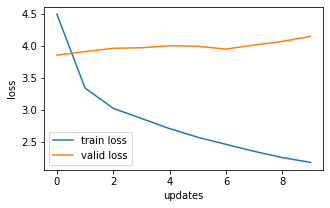

In [57]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [58]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, valid_loader, criterion, val_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.854 | Test PPL:  47.159 |


# 6. Real-world inference

In [59]:
torch.save(vocab_transform, 'vocab_obj.pth')

In [60]:
def generate(prompt, max_seq_len, temperature, model, tokenizer, vocab, device, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    model.eval()
    tokens = tokenizer(prompt)
    indices = [vocab[t] for t in tokens]
    batch_size = 1
    hidden = model.init_hidden(batch_size, device)
    with torch.no_grad():
        for i in range(max_seq_len):
            src = torch.LongTensor([indices]).to(device)
            prediction, hidden = model(src, hidden)
            
            #prediction: [batch size, seq len, vocab size]
            #prediction[:, -1]: [batch size, vocab size] #probability of last vocab
            
            probs = torch.softmax(prediction[:, -1] / temperature, dim=-1)  
            prediction = torch.multinomial(probs, num_samples=1).item()    
            
            while prediction == vocab['<unk>']: #if it is unk, we sample again
                prediction = torch.multinomial(probs, num_samples=1).item()

            if prediction == vocab['<eos>']:    #if it is eos, we stop
                break

            indices.append(prediction) #autoregressive, thus output becomes input

    itos = vocab.get_itos()
    tokens = [itos[i] for i in indices]
    return tokens

In [61]:
sample = "from tensorflow i"

In [62]:
sample_text = text_transform(sample[0]).to(device)
sample_text

tensor([   2, 1030,    3], device='cuda:0')

In [63]:
sample_text = sample_text.reshape(1, -1)  #because batch_size is 1

In [64]:
sample_text.shape

torch.Size([1, 3])

In [65]:
text_length = torch.tensor([sample_text.size(0)]).to(dtype=torch.int64)

In [66]:
model.load_state_dict(torch.load(save_path))

model.eval()
with torch.no_grad():
    output = model(sample_text) #turn off teacher forcing

In [67]:
output.shape

torch.Size([1, 3, 4398])

In [68]:
output = output.squeeze(0)

In [69]:
output.shape

torch.Size([3, 4398])

In [70]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([2, 4398])

In [71]:
output_max = output.argmax(1) #returns max indices

In [72]:
output_max

tensor([6, 6], device='cuda:0')

In [73]:
mapping = vocab_transform.get_itos()

In [74]:
for token in output_max:
    print(mapping[token.item()])

)
)
